# Fast Modular Exponentiation

In [41]:
# Imports
from numba import jit
import threading
import timeit
import pandas as pd
import matplotlib.pyplot as plt
plt.style.use('ggplot') # use ggplot style for more sophisticated visuals


# I.Right-to-Left Binary Modular Exponentiation

This algorithm is called right-to-left because it scans the exponent e bit-wise from right to left.

S is initialized to b and S ×S is calculated in each iteration, so it is also called repeated squaring.

In [2]:
@jit(nopython=True)
def rightToLeftBinaryModularExponentiation(b,e,p,q):    # y = b^e (mod n)
    A, S, k, n = 1, b, len(e), p*q
    for i in range (k):  # from 0 -> k-1
        if e[- (i + 1)] == '1':
            A = (A * S) % n
        S = (S * S) % n
    return A

rightToLeftBinaryModularExponentiation(6,"111", 1,1) # Just a warm up

0

# II.Left-to-Right Binary Modular Exponentiation

This algorithm first appeared 200 BCE in India but is known as “Left-to-right binary exponentiation” or a square and multiply algorithm. 

The Right-to-Left Algorithm described earlier computes A.S if e_i is 1. The computation A.b can sometimes be more effective for a fixed b instead of an arbitrary large S, especially if the base b is a small integer. 

This algorithm requires one temporary register less than the Right-to-Left version because the variable A is discarded.

In [63]:
@jit(nopython=True)
def leftToRightBinaryModularExponentiation(b,e,q,p):    # y = b^e (mod n)
    S, k, n = b, len(e), p*q
    for i in range (1, k,1):   # start from 0 ,end k-2 ,step 1
        S = (S * S) % n
        if e[i] == '1':
            S = ( S * b) % n
    return S
leftToRightBinaryModularExponentiation(6,"111", 1,1) # Just a warm up

0

# III.CRT

### Computation of b<sup>e</sup> (mod n) can be accelerated by using the Chinese Remainder Theorem (CRT).

Since the sender and receiver know the prime factors p, q of the modulus n = pq,
then we can first do the modular exponentiations in the smaller moduli p, q:
yp = b<sup>e</sup> (mod p), yq = be (mod q) (1)

Then, we combine the 2 results using CRT to get the final result in modulo n:
y = b<sup>e</sup> (mod n) ≡yp ×q ×xq + yq ×p ×xp (mod n) (2)

Where xq is the multiplicative inverse of q in modulo p and xp is the multiplicative inverse of p in modulo q. 

They can be obtained by solving the following linear congruences using extended GCD algorithm.
qxq ≡1 (mod p), pxp ≡1 (mod q) (3)

In [4]:
@jit(nopython=True)
def extendedEuclidGCD(a, b):  # returns gcd (a, b), x, y: gcd (a, b) = ax+by    
    if b == 0:
        d, x, y = a, 1, 0
    else:
        (d, p, q) = extendedEuclidGCD(b, a % b)
        x = q
        y = p - q * (a // b)
    
    return (d, x, y)

extendedEuclidGCD(1,10) # Just a warm up


(1, 1, 0)

In [46]:
# xq is the multiplicative inverse of q in modulo p
# xp is the multiplicative inverse of p in modulo q. 
@jit(nopython=True)
def CRT (b,e,q,p): 
    yp = leftToRightBinaryModularExponentiation(b,e,1,p)
    yq = leftToRightBinaryModularExponentiation(b,e,q,1)

    dq , xq , xp = extendedEuclidGCD(q,p)   # for (a,n):  dq = xq * a + yq * n 

    y = (yp * q * xq + yq * p * xp) % (p*q)
    return y
CRT(6,"111", 1,1) # Just a warm up

0

# CRT Parallelized

We can achieve a better performance by parallelizing the CRT.


In [127]:

def CRT_parallel (b,e,q,p): 
    def leftToRightBinaryModularExponentiation_edit(b,e,q,p):  # use leftToRightBinaryModularExponentiation to save the result  
        _y[q*p] = leftToRightBinaryModularExponentiation(b,e,q,p)
        return
    # pass y as a container for the thread 
    _y={}

    # creating thread
    t1 = threading.Thread(target=leftToRightBinaryModularExponentiation_edit, args=(b,e,1,p))
    t2 = threading.Thread(target=leftToRightBinaryModularExponentiation_edit, args=(b,e,q,1))
  
    # starting thread 1, 2
    t1.start()
    t2.start()
    _ , xq , xp = extendedEuclidGCD(q,p)   # for (a,n):  dq = xq * a + yq * n 
    
    # Join threads
    t1.join() # wait until thread 1 is completely executed
    t2.join() # wait until thread 2 is completely executed
  
    # both threads completely executed    
    y = (_y[p] * q * xq + _y[q] * p * xp) % (p*q)
    
    return y
CRT_parallel(6,"111", 1,1) # Just a warm up

0

# Test:
for: b = 11, e = 12354, p = 7919, q = 5153, n = pq = 40806607


In [89]:
def calculateRuntime(algorithm,b,e,q,p):
    start = timeit.default_timer()
    result = algorithm(b,e,q,p)
    end = timeit.default_timer()
    return([float(end - start),result])

In [128]:
binary = bin(12354)[2:]
b = 11
p = 7919
q = 5153

algorithm1_time , result1 =  calculateRuntime(rightToLeftBinaryModularExponentiation,b,binary,q,p)
algorithm2_time , result2 =  calculateRuntime(leftToRightBinaryModularExponentiation,b,binary,q,p)
algorithm3_time , result3 =  calculateRuntime(CRT,b,binary,q,p)
algorithm4_time , result4 =  calculateRuntime(CRT_parallel,b,binary,q,p)

data = {'Right to Left': [algorithm1_time , result1],
        'Left to Right': [algorithm2_time , result2],
        'CRT': [algorithm3_time , result3],
        'CRT_parallel': [algorithm4_time , result4]
        }
df = pd.DataFrame(data, index=['Time','Result'])
df.style.highlight_max(color = 'red', axis = None).highlight_min(color = 'lightgreen', axis = None)

df

,Right to Left,Left to Right,CRT,CRT_parallel
Time,2.675000e-05,7.790000e-06,7.681000e-06,8.388370e-04
Result,3.105740e+07,3.105740e+07,3.105740e+07,3.105740e+07


**Note**: CRT_parallel didn't result in an increased performance as it is not compiled using numba.


# Compare between the different algorithms

for: b = 11, p = 7919, q = 5153, n = pq = 40806607


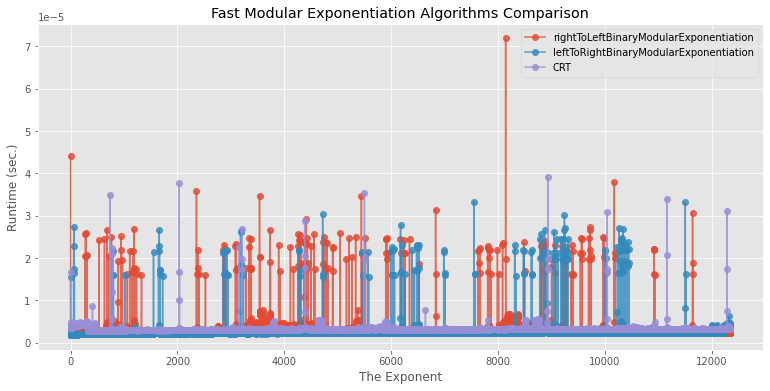

In [135]:
def runTestCases(algorithm, maxExp):
    runTime = []
    b = 11
    p = 7919
    q = 5153
    for e in range(maxExp):
        e = bin(e)[2:]
        start = timeit.default_timer()
        result = algorithm(b,e,q,p)
        end = timeit.default_timer()
        runTime.append(end - start)
    return(runTime)


def plotOnSameGraph(x):
    # this is the call to matplotlib that allows dynamic plotting
    plt.ion()
    fig = plt.figure(figsize=(13,6))
    ax = fig.add_subplot(111)
    ax.plot(x,runTestCases(rightToLeftBinaryModularExponentiation, len(x)),'-o',alpha=0.8)      
    ax.plot(x,runTestCases(leftToRightBinaryModularExponentiation, len(x)),'-o',alpha=0.8)      
    ax.plot(x,runTestCases(CRT, len(x)),'-o',alpha=0.8)      
    ax.legend(['rightToLeftBinaryModularExponentiation', 'leftToRightBinaryModularExponentiation', 'CRT'])

    plt.ylabel('Runtime (sec.)')
    plt.xlabel('The Exponent')
    plt.title("Fast Modular Exponentiation Algorithms Comparison")
    plt.show()

plotOnSameGraph(list(range(12345)))